In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd

In [3]:
df = pd.read_csv("/content/drive/My Drive/Master thesis/dataset/mbti_1.csv")
df.head()

,type,posts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1,ENTP,'I'm finding the lack of me in these posts ver...
2,INTP,'Good one _____ https://www.youtube.com/wat...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o..."
4,ENTJ,'You're fired.|||That's another silly misconce...


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8675 entries, 0 to 8674
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   type    8675 non-null   object
 1   posts   8675 non-null   object
dtypes: object(2)
memory usage: 135.7+ KB


In [5]:
df.shape

(8675, 2)

In [6]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [7]:
import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

sw = set(stopwords.words('english'))
ps = PorterStemmer()

In [8]:
def clean_text(sample):
  sample = sample.lower()

  sample = re.sub("[^a-zA-Z]+", " ", sample)

  sample = sample.split(" ")
  sample = [re.sub("http.*","",s) for s in sample if s not in sw]
  sample = [ps.stem(s) for s in sample]
  sample = " ".join(sample)
  return sample

In [9]:
df['cleaned_posts'] = df['posts'].apply(clean_text)

In [36]:
df.head()

,type,posts,cleaned_posts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,www youtub com watch v qsxhcwe krw media tu...
1,ENTP,'I'm finding the lack of me in these posts ver...,find lack post alarm sex bore posit often exa...
2,INTP,'Good one _____ https://www.youtube.com/wat...,good one www youtub com watch v fhigbolffgw ...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o...",dear intp enjoy convers day esoter gab natur ...
4,ENTJ,'You're fired.|||That's another silly misconce...,fire anoth silli misconcept approach logic go...


In [35]:
x = df['cleaned_posts']

In [29]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

cv = CountVectorizer( max_features=10000, ngram_range=(1,2))
cv.fit(x)
x=cv.transform(x)

tfidf = TfidfTransformer()
x = tfidf.fit_transform(x)

In [13]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

In [14]:
y = df['type'].values
y = le.fit_transform(y)

y[:100]

array([ 8,  3, 11, 10,  2, 10,  8, 10,  8, 11,  8,  0,  8, 10, 11, 11,  8,
        9,  8,  9, 11,  8,  2,  9,  2,  9,  1, 13,  9,  8,  9,  8, 11,  8,
        0,  8, 10,  9,  1,  2, 15,  8, 11,  9, 10, 11,  2,  9, 12, 10, 11,
        9, 12, 11,  9,  9,  9,  0, 11, 10,  8, 11,  9,  9,  3, 11, 13,  0,
        8,  0,  8,  9,  1, 15,  8, 11, 10, 10, 10,  9,  9,  8,  3,  2,  9,
       11,  9, 12, 14, 11,  3, 11, 13,  0,  8,  9,  8, 10,  8,  1])

In [37]:
from sklearn.model_selection import train_test_split

xtrain,xtest,ytrain,ytest=train_test_split(x,y,shuffle=True,test_size=0.3)
print(xtrain.shape,ytrain.shape,xtest.shape,ytest.shape)

(6072,) (6072,) (2603,) (2603,)


In [33]:
import numpy as np

np.unique(ytrain)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15])

In [38]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

cv = CountVectorizer( max_features=10000, ngram_range=(1,2))
cv.fit(xtrain)
x_train=cv.transform(xtrain)

In [39]:
params={
 "learning_rate"    : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ] ,
 "max_depth"        : [ 3, 4, 5, 6, 8, 10, 12, 15],
 "min_child_weight" : [ 1, 3, 5, 7 ],
 "gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
 "colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ]
    
}

In [40]:
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier

In [41]:
def timer(start_time=None):
    if not start_time:
        start_time = datetime.now()
        return start_time
    elif start_time:
        thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
        tmin, tsec = divmod(temp_sec, 60)
        print('\n Time taken: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))

In [42]:

classifier=XGBClassifier()

In [57]:
random_search=RandomizedSearchCV(classifier,param_distributions=params,n_iter=5,scoring='roc_auc_ovr_weighted',n_jobs=-1,cv=5,verbose=3)

In [58]:
from datetime import datetime
# Here we go
start_time = timer(None) # timing starts from this point for "start_time" variable
random_search.fit(x_train,ytrain)
timer(start_time) # timing ends here for "start_time" variable

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed: 40.0min finished



 Time taken: 0 hours 41 minutes and 28.69 seconds.


In [59]:
random_search.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.3, gamma=0.1,
              learning_rate=0.1, max_delta_step=0, max_depth=4,
              min_child_weight=7, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [60]:
random_search.best_params_

{'colsample_bytree': 0.3,
 'gamma': 0.1,
 'learning_rate': 0.1,
 'max_depth': 4,
 'min_child_weight': 7}

In [61]:
classifier=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.3, gamma=0.1,
              learning_rate=0.1, max_delta_step=0, max_depth=4,
              min_child_weight=7, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [66]:
classifier.fit(x_train,ytrain)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.3, gamma=0.1,
              learning_rate=0.1, max_delta_step=0, max_depth=4,
              min_child_weight=7, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [62]:
from sklearn.model_selection import cross_val_score

score=cross_val_score(classifier,x_train,ytrain,cv=10)

In [63]:
score

array([0.65789474, 0.67105263, 0.67051071, 0.67215815, 0.66886326,
       0.70510708, 0.68698517, 0.65733114, 0.70510708, 0.69192751])

In [64]:
score.mean()

0.6786937483742305

In [69]:
pred = classifier.predict(cv.transform(xtest))

In [74]:
from sklearn.metrics import classification_report, confusion_matrix

cm = confusion_matrix(ytest,pred)
cm

array([[ 16,   5,   0,   1,   0,   0,   0,   0,  13,  15,   5,   2,   0,
          0,   0,   3],
       [  1, 127,   1,   6,   0,   0,   0,   0,   9,  22,  18,   5,   0,
          0,   1,   3],
       [  1,   2,  18,  11,   0,   0,   1,   0,   4,   9,  10,   7,   0,
          0,   1,   1],
       [  0,   8,   1, 126,   0,   0,   0,   2,  21,  13,  15,  19,   0,
          0,   0,   1],
       [  1,   0,   0,   1,   0,   0,   0,   0,   3,   0,   0,   5,   1,
          0,   1,   0],
       [  0,   2,   0,   3,   0,   0,   0,   0,   0,   3,   5,   3,   0,
          0,   0,   0],
       [  0,   0,   1,   0,   0,   0,   2,   0,   0,   2,   0,   1,   0,
          0,   0,   0],
       [  0,   0,   0,   1,   0,   0,   0,   5,   4,   5,   8,   6,   0,
          0,   0,   2],
       [  0,   7,   1,   8,   0,   0,   0,   0, 330,  52,  24,  19,   0,
          1,   0,   3],
       [  1,  11,   0,   7,   0,   0,   0,   0,  26, 480,  17,  19,   2,
          4,   1,   5],
       [  0,   2,   1,  12,   

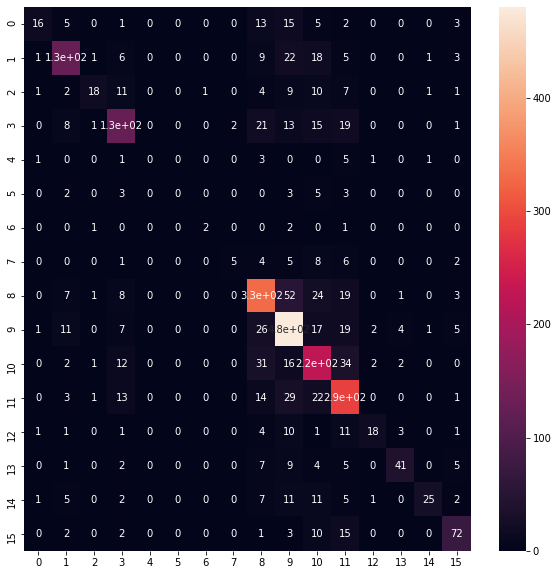

In [75]:
import seaborn as sn
import matplotlib.pyplot as plt

plt.figure(figsize = (10,10))
sn.heatmap(cm, annot=True)

In [77]:
print('classification_report :\n',classification_report(ytest, pred))

classification_report :
               precision    recall  f1-score   support

           0       0.73      0.27      0.39        60
           1       0.72      0.66      0.69       193
           2       0.75      0.28      0.40        65
           3       0.64      0.61      0.63       206
           4       0.00      0.00      0.00        12
           5       0.00      0.00      0.00        16
           6       0.67      0.33      0.44         6
           7       0.71      0.16      0.26        31
           8       0.70      0.74      0.72       445
           9       0.71      0.84      0.77       573
          10       0.60      0.69      0.64       325
          11       0.65      0.78      0.71       371
          12       0.75      0.35      0.48        51
          13       0.80      0.55      0.66        74
          14       0.86      0.36      0.51        70
          15       0.73      0.69      0.71       105

    accuracy                           0.68      2603
 

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [80]:
import joblib

joblib.dump(classifier,'/content/drive/My Drive/Master thesis/model_1.pkl')

['/content/drive/My Drive/Master thesis/model_1.pkl']

In [81]:
joblib.load('model_1.pkl')

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.3, gamma=0.1,
              learning_rate=0.1, max_delta_step=0, max_depth=4,
              min_child_weight=7, missing=nan, n_estimators=100, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)